In [912]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import KFold, RepeatedKFold
from scipy import sparse
import warnings
import time
import sys
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
pd.set_option('max_colwidth',100)

In [913]:
train_df = pd.read_csv("./jinnan_round1_train_20181227.csv", encoding = 'gb18030')
test_df = pd.read_csv("./jinnan_round1_testA_20181227.csv", encoding = 'gb18030')

In [914]:
'''
train_df['A21'] = train_df['A21'].fillna(train_df['A21'].median())
train_df['B1'] = train_df['B1'].fillna(train_df['B1'].median())
train_df['B8'] = train_df['B8'].fillna(train_df['B8'].median())
train_df['B12'] = train_df['B12'].fillna(train_df['B12'].median())
def processError(df):
    if df == '1900/3/10 0:00':
        return 70
    return df
train_df['A25'] = train_df['A25'].apply(lambda x: processError(x))
train_df['A25'] = train_df['A25'].fillna(train_df['A25'].median())
train_df['A23'] = train_df['A23'].fillna(train_df['A23'].median())
train_df['B2'] = train_df['B2'].fillna(train_df['B2'].median())
train_df['B3'] = train_df['B3'].fillna(train_df['B3'].median())
train_df['B13'] = train_df['B13'].fillna(train_df['B13'].median())
'''

"\ntrain_df['A21'] = train_df['A21'].fillna(train_df['A21'].median())\ntrain_df['B1'] = train_df['B1'].fillna(train_df['B1'].median())\ntrain_df['B8'] = train_df['B8'].fillna(train_df['B8'].median())\ntrain_df['B12'] = train_df['B12'].fillna(train_df['B12'].median())\ndef processError(df):\n    if df == '1900/3/10 0:00':\n        return 70\n    return df\ntrain_df['A25'] = train_df['A25'].apply(lambda x: processError(x))\ntrain_df['A25'] = train_df['A25'].fillna(train_df['A25'].median())\ntrain_df['A23'] = train_df['A23'].fillna(train_df['A23'].median())\ntrain_df['B2'] = train_df['B2'].fillna(train_df['B2'].median())\ntrain_df['B3'] = train_df['B3'].fillna(train_df['B3'].median())\ntrain_df['B13'] = train_df['B13'].fillna(train_df['B13'].median())\n"

In [915]:
'''
test_df['A25'] = test_df['A25'].fillna(train_df['A25'].median())
test_df['A27'] = test_df['A27'].fillna(train_df['A27'].median())
test_df['B1'] = test_df['B1'].fillna(train_df['B1'].median())
'''

"\ntest_df['A25'] = test_df['A25'].fillna(train_df['A25'].median())\ntest_df['A27'] = test_df['A27'].fillna(train_df['A27'].median())\ntest_df['B1'] = test_df['B1'].fillna(train_df['B1'].median())\n"

In [916]:
views = []
for col in train_df.columns:
    views.append((col, train_df[col].nunique(), train_df[col].isnull().sum() * 100 / train_df.shape[0], train_df[col].value_counts(normalize=True, dropna=False).values[0] * 100, train_df[col].dtype))
views_df = pd.DataFrame(views, columns=['Feature','value_count','null_percent','most_value_count','type'])
views_df.sort_values('null_percent', ascending=False)

,Feature,value_count,null_percent,most_value_count,type
2,A2,1,96,96.991404,float64
7,A7,75,89,89.326648,object
8,A8,8,89,89.326648,float64
39,B11,37,60,60.816619,object
38,B10,180,17,17.478510,object
3,A3,3,3,95.702006,float64
0,sample id,1396,0,0.071633,object
33,B5,60,0,17.550143,object
26,A26,88,0,18.982808,object
27,A27,13,0,45.128940,int64


In [917]:
views = []
for col in test_df.columns:
    views.append((col, test_df[col].nunique(), test_df[col].isnull().sum() * 100 / test_df.shape[0], test_df[col].value_counts(normalize=True, dropna=False).values[0] * 100, test_df[col].dtype))
views_df = pd.DataFrame(views, columns=['Feature','value_count','null_percent','most_value_count','type'])
views_df.sort_values('null_percent', ascending=False)

,Feature,value_count,null_percent,most_value_count,type
2,A2,1,98,98.000000,float64
7,A7,15,88,88.000000,object
8,A8,2,88,88.000000,float64
39,B11,11,59,59.333333,object
38,B10,50,14,14.666667,object
3,A3,2,2,97.333333,float64
0,sample id,150,0,0.666667,object
32,B4,51,0,20.666667,object
26,A26,41,0,21.333333,object
27,A27,11,0,47.333333,float64


In [918]:
for df in [train_df, test_df]:
    df.drop(['B3', 'B13', 'A13', 'A18', 'A23'], axis=1, inplace=True)

features = list(train_df.columns)
for col in train_df.columns:
    rate = train_df[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        features.remove(col)
train_df = train_df[features]
features.remove('score')
test_df = test_df[features]

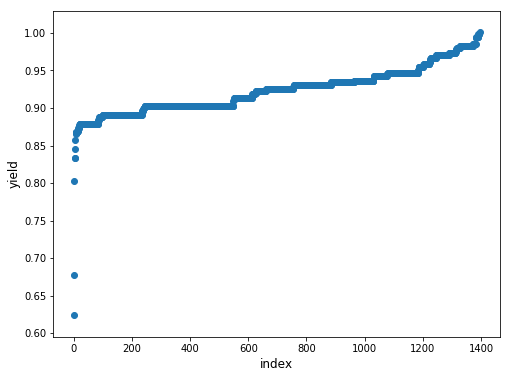

In [919]:
target_col = 'score'
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df[target_col].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('yield', fontsize=12)
plt.show()

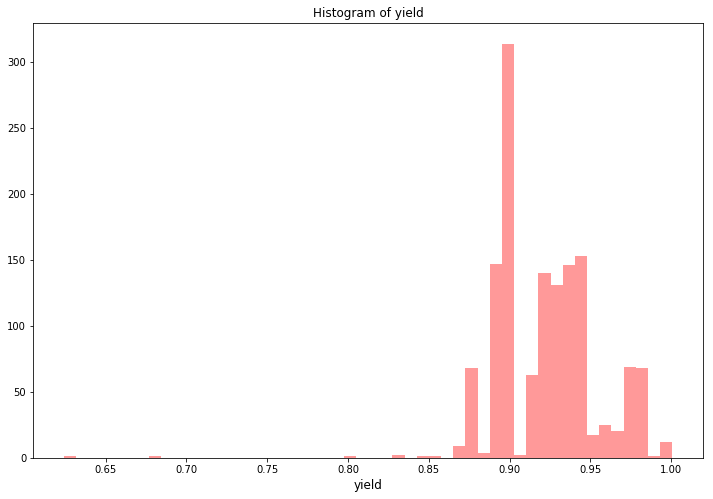

In [920]:
plt.figure(figsize=(12,8))
sns.distplot(train_df[target_col].values, bins=50, kde=False, color="red")
plt.title("Histogram of yield")
plt.xlabel('yield', fontsize=12)
plt.show()

In [921]:
train_df = train_df[train_df[target_col]>0.87]

In [922]:
def TimeToInt(t, previous = 0):
    try:
        t,m,s=t.split(":")
    except:
        if t=='1900/1/9 7:00':
            return 7*3600/3600
        elif t=='1900/1/1 2:30':
            return (2*3600+30*60)/3600
        elif t==-1:
            return -1
        else:
            return 0
    
    try:
        tm = (int(t)*3600+int(m)*60+int(s))/3600
        if tm < previous:
            tm += 24
    except:
        return (30*60)/3600
    
    return tm

def TimeToDuration(se):
    try:
        sh,sm,eh,em=re.findall(r"\d+\.?\d*",se)
    except:
        if se == -1:
            return -1
    try:
        duration = (int(eh)*60+int(em)-int(sm)-int(sh)*60)/60
        if duration < 0:
            duration += 24
        return duration
    except:
        return 0

def Between(t1, t2):
    if t1 < 0 or t2 < 0:
        return -1
    duration = 0
    try:
        duration = t1 - t2
        if duration < 0:
            duration += 24
    except:
        duration = 0
    return duration

def getBeforeTime(se):
    try:
        sh,sm,eh,em=re.findall(r"\d+\.?\d*",se)
    except:
        if se == -1:
            return -1       
    try:
        tm = (int(sh)*3600+int(sm)*60)/3600
    except:
        if se=='19:-20:05':
            return (19*3600+5*60)/3600
        elif se=='15:00-1600':
            return 15*3600/3600       
    return tm

def adjust(t1, t2):
    if t1 < 0 or t2 < 0:
        return -1
    if t1 < t2:
        return t1 + 24
    return t1

def getAfterTime(t1, t2):
    if t1 < 0 or t2 < 0:
        return -1
    if t1 < 0 or  t2 < 0:
        return -1
    return t1 + t2

In [923]:
target = train_df['score']
del train_df['score']
data = pd.concat([train_df,test_df],axis=0,ignore_index=True)
data = data.fillna(-1)

In [924]:
for f in ['A5','A7','A9','A11','A14','A16','A24','A26','B5','B7']:
    data[f] = data[f].apply(TimeToInt)

In [925]:
for f in ['A20', 'A28', 'B4', 'B9', 'B10', 'B11']:
    data[f+'_duration'] = data.apply(lambda data: TimeToDuration(data[f]), axis=1)

In [926]:
for f in ['A20','A28','B4','B9','B10','B11']:
    data[f+'_before_time'] = data.apply(lambda data: getBeforeTime(data[f]), axis=1)
    
for f in ['A20','A28','B4','B9','B10','B11']:
    data[f+'_after_time'] = data.apply(lambda data: getAfterTime(data[f+'_before_time'], data[f+'_duration']), axis=1)
    del data[f]

In [927]:
for f in [['A7', 'A5'],['A9', 'A5'],['A11', 'A9'],['A14', 'A11'],['A16', 'A14'],['A24', 'A16'],['A26', 'A24'],['B5', 'A26'],['B7', 'B5']]:
        data[f[0]] = data.apply(lambda data: adjust(data[f[0]], data[f[1]]), axis=1)

for f in [['A20_before_time','A16'],['A28_before_time', 'A26'],['B4_before_time','A28_before_time'],['B9_before_time', 'A5'],['B10_before_time','A5'],['B11_before_time','A5']]:
    data[f[0]] = data.apply(lambda data: adjust(data[f[0]], data[f[1]]), axis=1)
    
for f in [['A20_after_time','A20_before_time'],['A28_after_time', 'A28_before_time'],['B4_after_time','B4_before_time'],['B9_after_time', 'B9_before_time'],['B10_after_time','B10_before_time'],['B11_after_time','B11_before_time']]:
    data[f[0]] = data.apply(lambda data: adjust(data[f[0]], data[f[1]]), axis=1)

In [928]:
for f in [['A20_before_time','A5'],['A28_before_time', 'A5'],['B4_before_time','A5'],['B9_before_time', 'A5'],['B10_before_time','A5'],['B11_before_time','A5']]:
    data[f[0]] = data.apply(lambda data: Between(data[f[0]], data[f[1]]), axis=1)
for f in [['A20_after_time','A5'],['A28_after_time', 'A5'],['B4_after_time','A5'],['B9_after_time', 'A5'],['B10_after_time','A5'],['B11_after_time','A5']]:
    data[f[0]] = data.apply(lambda data: Between(data[f[0]], data[f[1]]), axis=1)
for f in [['A7', 'A5'],['A9', 'A5'],['A11', 'A5'],['A14', 'A5'],['A16', 'A5'],['A24', 'A5'],['A26', 'A5'],['B5', 'A5'],['B7', 'A5']]:
    data[f[0]] = data.apply(lambda data: Between(data[f[0]], data[f[1]]), axis=1)

In [929]:
def processError(df):
    if df == '1900/3/10 0:00':
        return 70
    return df
data['A25'] = data['A25'].apply(lambda x: processError(x)).astype(int)
for f in [['A8','A6'],['A10','A6'],['A12','A6'],['A15','A6'],['A17','A6'],['A21','A6'],['A25','A6'],['A27', 'A6']]:
    data[f[0]+'_dis'] = data.apply(lambda data: Between(data[f[0]], data[f[1]]), axis=1)
del data['A6']

In [930]:
data.head()

,sample id,A5,A7,A8,A9,A10,A11,A12,A14,A15,A16,A17,A19,A21,A22,A24,A25,A26,A27,B1,B5,B6,B7,B8,B12,B14,A20_duration,A28_duration,B4_duration,B9_duration,B10_duration,B11_duration,A20_before_time,A28_before_time,B4_before_time,B9_before_time,B10_before_time,B11_before_time,A20_after_time,A28_after_time,B4_after_time,B9_after_time,B10_after_time,B11_after_time,A8_dis,A10_dis,A12_dis,A15_dis,A17_dis,A21_dis,A25_dis,A27_dis
0,sample_1528,13,-1,-1.0,2,100,3,102.0,4,103.0,5,104.0,300,50.0,9.0,9,75,9,70.0,350.0,19,65,22,45.0,800.0,400,0,0,1,1,1,-1,8,17,18,22,1,-1,8,17,19,23,2,-1,-1.0,62.0,64.0,65.0,66.0,12.0,37.0,32.0
1,sample_1698,14,-1,-1.0,2,101,3,103.0,4,104.0,5,105.0,200,50.0,9.0,6,80,7,73.0,320.0,9,80,16,45.0,1200.0,400,1,1,1,1,1,1,5,7,8,16,17,19,6,8,9,17,18,20,-1.0,72.0,74.0,75.0,76.0,21.0,51.0,44.0
2,sample_639,14,-1,-1.0,2,102,3,103.0,4,104.0,5,105.0,200,50.0,9.0,6,79,7,73.0,320.0,9,80,11,45.0,1200.0,400,0,1,1,1,1,1,5,7,8,11,12,14,5,8,9,12,13,15,-1.0,73.0,74.0,75.0,76.0,21.0,50.0,44.0
3,sample_483,1,-1,-1.0,2,100,3,102.0,4,103.0,5,104.0,200,50.0,10.0,6,70,7,78.0,290.0,14,65,17,45.0,800.0,400,0,1,1,1,1,-1,5,12,13,18,20,-1,5,13,14,19,21,-1,-1.0,62.0,64.0,65.0,66.0,12.0,32.0,40.0
4,sample_617,22,-1,-1.0,2,101,3,103.0,4,104.0,5,105.0,200,50.0,9.0,6,80,7,73.0,320.0,9,80,11,45.0,1200.0,420,1,1,1,1,1,1,5,7,8,11,12,14,6,8,9,12,13,15,-1.0,72.0,74.0,75.0,76.0,21.0,51.0,44.0


In [931]:
cate_columns = [f for f in data.columns if f != 'sample id']
#label encoder
for f in cate_columns:
    data[f] = data[f].map(dict(zip(data[f].unique(), range(0, data[f].nunique()))))
train = data[:train_df.shape[0]]
test  = data[train_df.shape[0]:]

In [932]:
train['target'] = target
train['intTarget'] = pd.cut(train['target'], 5, labels=False)
train = pd.get_dummies(train, columns=['intTarget'])
train.head()

,sample id,A5,A7,A8,A9,A10,A11,A12,A14,A15,A16,A17,A19,A21,A22,A24,A25,A26,A27,B1,B5,B6,B7,B8,B12,B14,A20_duration,A28_duration,B4_duration,B9_duration,B10_duration,B11_duration,A20_before_time,A28_before_time,B4_before_time,B9_before_time,B10_before_time,B11_before_time,A20_after_time,A28_after_time,B4_after_time,B9_after_time,B10_after_time,B11_after_time,A8_dis,A10_dis,A12_dis,A15_dis,A17_dis,A21_dis,A25_dis,A27_dis,target,intTarget_0.0,intTarget_1.0,intTarget_2.0,intTarget_3.0,intTarget_4.0
0,sample_1528,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.879,1,0,0,0,0
1,sample_1698,1,0,0,0,1,0,1,0,1,0,1,1,0,0,1,1,1,1,1,1,1,1,0,1,0,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0.902,0,1,0,0,0
2,sample_639,1,0,0,0,2,0,1,0,1,0,1,1,0,0,1,2,1,1,1,1,1,2,0,1,0,0,1,0,0,0,1,1,1,1,2,2,2,2,1,1,2,2,2,0,2,1,1,1,1,2,1,0.936,0,0,1,0,0
3,sample_483,2,0,0,0,0,0,0,0,0,0,0,1,0,1,1,3,1,2,2,2,0,3,0,0,0,0,1,0,0,0,0,1,2,2,3,3,0,2,2,2,3,3,0,0,0,0,0,0,0,3,2,0.902,0,1,0,0,0
4,sample_617,3,0,0,0,1,0,1,0,1,0,1,1,0,0,1,1,1,1,1,1,1,2,0,1,1,1,1,0,0,0,1,1,1,1,2,2,2,1,1,1,2,2,2,0,1,1,1,1,1,1,1,0.983,0,0,0,0,1


In [933]:
li = ['intTarget_0.0','intTarget_1.0','intTarget_2.0','intTarget_3.0','intTarget_4.0']
mean_features = []
for f1 in cate_columns:
    for f2 in li:
        col_name = f1+"_"+f2+'_mean'
        mean_features.append(col_name)
        order_label = train.groupby([f1])[f2].mean()
        for df in [train, test]:
            df[col_name] = df[f].map(order_label)

train.drop(li, axis=1, inplace=True)

In [934]:
train.head()

,sample id,A5,A7,A8,A9,A10,A11,A12,A14,A15,A16,A17,A19,A21,A22,A24,A25,A26,A27,B1,B5,B6,B7,B8,B12,B14,A20_duration,A28_duration,B4_duration,B9_duration,B10_duration,B11_duration,A20_before_time,A28_before_time,B4_before_time,B9_before_time,B10_before_time,B11_before_time,A20_after_time,A28_after_time,B4_after_time,B9_after_time,B10_after_time,B11_after_time,A8_dis,A10_dis,A12_dis,A15_dis,A17_dis,A21_dis,A25_dis,A27_dis,target,A5_intTarget_0.0_mean,A5_intTarget_1.0_mean,A5_intTarget_2.0_mean,A5_intTarget_3.0_mean,A5_intTarget_4.0_mean,A7_intTarget_0.0_mean,A7_intTarget_1.0_mean,A7_intTarget_2.0_mean,A7_intTarget_3.0_mean,A7_intTarget_4.0_mean,A8_intTarget_0.0_mean,A8_intTarget_1.0_mean,A8_intTarget_2.0_mean,A8_intTarget_3.0_mean,A8_intTarget_4.0_mean,A9_intTarget_0.0_mean,A9_intTarget_1.0_mean,A9_intTarget_2.0_mean,A9_intTarget_3.0_mean,A9_intTarget_4.0_mean,A10_intTarget_0.0_mean,A10_intTarget_1.0_mean,A10_intTarget_2.0_mean,A10_intTarget_3.0_mean,A10_intTarget_4.0_mean,A11_intTarget_0.0_mean,A11_intTarget_1.0_mean,A11_intTarget_2.0_mean,A11_intTarget_3.0_mean,A11_intTarget_4.0_mean,A12_intTarget_0.0_mean,A12_intTarget_1.0_mean,A12_intTarget_2.0_mean,A12_intTarget_3.0_mean,A12_intTarget_4.0_mean,A14_intTarget_0.0_mean,A14_intTarget_1.0_mean,A14_intTarget_2.0_mean,A14_intTarget_3.0_mean,A14_intTarget_4.0_mean,A15_intTarget_0.0_mean,A15_intTarget_1.0_mean,A15_intTarget_2.0_mean,A15_intTarget_3.0_mean,A15_intTarget_4.0_mean,A16_intTarget_0.0_mean,A16_intTarget_1.0_mean,A16_intTarget_2.0_mean,A16_intTarget_3.0_mean,A16_intTarget_4.0_mean,A17_intTarget_0.0_mean,A17_intTarget_1.0_mean,A17_intTarget_2.0_mean,A17_intTarget_3.0_mean,A17_intTarget_4.0_mean,A19_intTarget_0.0_mean,A19_intTarget_1.0_mean,A19_intTarget_2.0_mean,A19_intTarget_3.0_mean,A19_intTarget_4.0_mean,A21_intTarget_0.0_mean,A21_intTarget_1.0_mean,A21_intTarget_2.0_mean,A21_intTarget_3.0_mean,A21_intTarget_4.0_mean,A22_intTarget_0.0_mean,A22_intTarget_1.0_mean,A22_intTarget_2.0_mean,A22_intTarget_3.0_mean,A22_intTarget_4.0_mean,A24_intTarget_0.0_mean,A24_intTarget_1.0_mean,A24_intTarget_2.0_mean,A24_intTarget_3.0_mean,A24_intTarget_4.0_mean,A25_intTarget_0.0_mean,A25_intTarget_1.0_mean,A25_intTarget_2.0_mean,A25_intTarget_3.0_mean,A25_intTarget_4.0_mean,A26_intTarget_0.0_mean,A26_intTarget_1.0_mean,A26_intTarget_2.0_mean,A26_intTarget_3.0_mean,A26_intTarget_4.0_mean,A27_intTarget_0.0_mean,A27_intTarget_1.0_mean,A27_intTarget_2.0_mean,A27_intTarget_3.0_mean,A27_intTarget_4.0_mean,B1_intTarget_0.0_mean,B1_intTarget_1.0_mean,B1_intTarget_2.0_mean,B1_intTarget_3.0_mean,B1_intTarget_4.0_mean,B5_intTarget_0.0_mean,B5_intTarget_1.0_mean,B5_intTarget_2.0_mean,B5_intTarget_3.0_mean,B5_intTarget_4.0_mean,B6_intTarget_0.0_mean,B6_intTarget_1.0_mean,B6_intTarget_2.0_mean,B6_intTarget_3.0_mean,B6_intTarget_4.0_mean,B7_intTarget_0.0_mean,B7_intTarget_1.0_mean,B7_intTarget_2.0_mean,B7_intTarget_3.0_mean,B7_intTarget_4.0_mean,B8_intTarget_0.0_mean,B8_intTarget_1.0_mean,B8_intTarget_2.0_mean,B8_intTarget_3.0_mean,B8_intTarget_4.0_mean,B12_intTarget_0.0_mean,B12_intTarget_1.0_mean,B12_intTarget_2.0_mean,B12_intTarget_3.0_mean,B12_intTarget_4.0_mean,B14_intTarget_0.0_mean,B14_intTarget_1.0_mean,B14_intTarget_2.0_mean,B14_intTarget_3.0_mean,B14_intTarget_4.0_mean,A20_duration_intTarget_0.0_mean,A20_duration_intTarget_1.0_mean,A20_duration_intTarget_2.0_mean,A20_duration_intTarget_3.0_mean,A20_duration_intTarget_4.0_mean,A28_duration_intTarget_0.0_mean,A28_duration_intTarget_1.0_mean,A28_duration_intTarget_2.0_mean,A28_duration_intTarget_3.0_mean,A28_duration_intTarget_4.0_mean,B4_duration_intTarget_0.0_mean,B4_duration_intTarget_1.0_mean,B4_duration_intTarget_2.0_mean,B4_duration_intTarget_3.0_mean,B4_duration_intTarget_4.0_mean,B9_duration_intTarget_0.0_mean,B9_duration_intTarget_1.0_mean,B9_duration_intTarget_2.0_mean,B9_duration_intTarget_3.0_mean,B9_duration_intTarget_4.0_mean,B10_duration_intTarget_0.0_mean,B10_duration_intTarget_1.0_mean,B10_duration_intTarget_2.0_mean,B10_duration_i

In [935]:
train.drop(['sample id','target'], axis=1, inplace=True)
test = test[train.columns]
X_train = train.values
y_train = target.values
X_test = test.values

In [936]:
def lgbFeval(preds, xgbtrain):
    label = xgbtrain.get_label()
    score = mean_squared_error(label,preds)*0.5
    return 'lgbFeval',score,False

param = {'num_leaves': 120,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    clf = lgb.train(param, 
                    trn_data, 
                    num_boost_round=10000, 
                    valid_sets = [trn_data, val_data], 
                    verbose_eval = 200, 
                    feval = lgbFeval,
                    early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("LGB score: {}".format(mean_squared_error(oof_lgb, target)))

fold n°1
Training until validation scores don't improve for 200 rounds.
[200]	training's l2: 0.000256893	training's lgbFeval: 0.000128446	valid_1's l2: 0.000269126	valid_1's lgbFeval: 0.000134563
[400]	training's l2: 0.00020139	training's lgbFeval: 0.000100695	valid_1's l2: 0.000231099	valid_1's lgbFeval: 0.00011555
[600]	training's l2: 0.000173986	training's lgbFeval: 8.69928e-05	valid_1's l2: 0.000219708	valid_1's lgbFeval: 0.000109854
[800]	training's l2: 0.000157349	training's lgbFeval: 7.86743e-05	valid_1's l2: 0.000216218	valid_1's lgbFeval: 0.000108109
[1000]	training's l2: 0.000146512	training's lgbFeval: 7.32558e-05	valid_1's l2: 0.000213258	valid_1's lgbFeval: 0.000106629
[1200]	training's l2: 0.000138928	training's lgbFeval: 6.94639e-05	valid_1's l2: 0.000212367	valid_1's lgbFeval: 0.000106184
[1400]	training's l2: 0.000133463	training's lgbFeval: 6.67317e-05	valid_1's l2: 0.000211863	valid_1's lgbFeval: 0.000105932
[1600]	training's l2: 0.000129043	training's lgbFeval: 6.45

In [937]:
def xgbFeval(preds, xgbtrain):
    label = xgbtrain.get_label()
    score = mean_squared_error(label,preds)*0.5
    return 'xgbFeval',score
##### xgb
xgb_params = {'eta': 0.002, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, feval = xgbFeval, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=200, params=xgb_params)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits

print("XGB score: {}".format(mean_squared_error(oof_xgb, target)))

fold n°1
[0]	train-rmse:0.424203	valid_data-rmse:0.425093	train-xgbFeval:0.089974	valid_data-xgbFeval:0.090352
Multiple eval metrics have been passed: 'valid_data-xgbFeval' will be used for early stopping.

Will train until valid_data-xgbFeval hasn't improved in 200 rounds.
[200]	train-rmse:0.28499	valid_data-rmse:0.285942	train-xgbFeval:0.04061	valid_data-xgbFeval:0.040881
[400]	train-rmse:0.191793	valid_data-rmse:0.192736	train-xgbFeval:0.018392	valid_data-xgbFeval:0.018574
[600]	train-rmse:0.129489	valid_data-rmse:0.130403	train-xgbFeval:0.008384	valid_data-xgbFeval:0.008502
[800]	train-rmse:0.087915	valid_data-rmse:0.088788	train-xgbFeval:0.003864	valid_data-xgbFeval:0.003942
[1000]	train-rmse:0.060289	valid_data-rmse:0.061171	train-xgbFeval:0.001817	valid_data-xgbFeval:0.001871
[1200]	train-rmse:0.041998	valid_data-rmse:0.043033	train-xgbFeval:0.000882	valid_data-xgbFeval:0.000926
[1400]	train-rmse:0.029913	valid_data-rmse:0.031357	train-xgbFeval:0.000447	valid_data-xgbFeval:0.000

[600]	train-rmse:0.129568	valid_data-rmse:0.129297	train-xgbFeval:0.008394	valid_data-xgbFeval:0.008359
[800]	train-rmse:0.087987	valid_data-rmse:0.087738	train-xgbFeval:0.003871	valid_data-xgbFeval:0.003849
[1000]	train-rmse:0.060337	valid_data-rmse:0.060161	train-xgbFeval:0.00182	valid_data-xgbFeval:0.00181
[1200]	train-rmse:0.042037	valid_data-rmse:0.042079	train-xgbFeval:0.000884	valid_data-xgbFeval:0.000885
[1400]	train-rmse:0.029966	valid_data-rmse:0.030396	train-xgbFeval:0.000449	valid_data-xgbFeval:0.000462
[1600]	train-rmse:0.022057	valid_data-rmse:0.023038	train-xgbFeval:0.000243	valid_data-xgbFeval:0.000265
[1800]	train-rmse:0.016862	valid_data-rmse:0.018544	train-xgbFeval:0.000142	valid_data-xgbFeval:0.000172
[2000]	train-rmse:0.01351	valid_data-rmse:0.015923	train-xgbFeval:9.1e-05	valid_data-xgbFeval:0.000127
[2200]	train-rmse:0.011374	valid_data-rmse:0.014421	train-xgbFeval:6.5e-05	valid_data-xgbFeval:0.000104
[2400]	train-rmse:0.01001	valid_data-rmse:0.013584	train-xgbFe

In [938]:
# 将lgb和xgb的结果进行stacking
train_stack = np.vstack([oof_lgb,oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
print("STACK score: {}".format(mean_squared_error(target.values, oof_stack)))

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
STACK score: 0.000209007932865


In [939]:
print("LGB score: {}".format(mean_squared_error(oof_lgb, target)))
print("XGB score: {}".format(mean_squared_error(oof_xgb, target)))
print("STACK score: {}".format(mean_squared_error(target.values, oof_stack)))
sub_df = pd.read_csv('submission.csv', header=None)
sub_df[1] = predictions
sub_df[1] = sub_df[1].apply(lambda x:round(x, 3))
sub_df.to_csv("submission.csv", index=False, header=None)

LGB score: 0.000226825967431
XGB score: 0.000212572544581
STACK score: 0.000209007932865
